In [47]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn.functional as F
import numpy as np
import pandas as pd
import math as math
import matplotlib.pyplot as plt

In [48]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [49]:
BATCH_SIZE = 100
NUM_EPOCHS = 20
DATA_PATH = "data/"
TRAIN_PATH = DATA_PATH + "train.csv"
TEST_PATH = DATA_PATH + "test.csv"
IMAGE_SIZE = 28
NUM_CLASSES = 10
LEARNING_RATE = 0.001
TEST_OUTPUT_PATH = DATA_PATH + "my_submission_cnn_with_validation_new.csv"

In [50]:
class DigitsDataset(Dataset):
    
    def __init__(self, csv_path):
        self.raw_csv = pd.read_csv(csv_path)
    
    def __getitem__(self, index):
        image = torch.tensor(self.raw_csv.iloc[index, 1:]).reshape(-1,IMAGE_SIZE,IMAGE_SIZE).to(torch.float32) # 1 x 28 x 28
        label = F.one_hot(torch.tensor(self.raw_csv.iloc[index, 0]), num_classes=NUM_CLASSES).to(torch.float32) # 1 x 10
        return (image, label)
    
    def __len__(self):
        return len(self.raw_csv)
    
    
    

In [51]:
class ConvNeuralNet(nn.Module):
    def __init__(self, num_classes):
        super(ConvNeuralNet, self).__init__()
        self.num_classes = num_classes
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(5,5), stride=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3,3))
        self.pool = nn.MaxPool2d(kernel_size=(2,2), stride=2)
        self.fc1 = nn.Linear(64*5*5, 200)
        self.fc2 = nn.Linear(200, self.num_classes)

    
    def forward(self, x):
        out = x # 1 x 28 x 28
        out = F.relu(self.conv1(x)) # 1 x 32 x 24 x 24
        out = self.pool(out) # 1 x 32 x 12 x 12
        out = F.relu(self.conv2(out)) # 1 x 64 x 10 x 10
        out = self.pool(out) # 1 x 64 x 5 x 5
        out = out.reshape(-1, 64*5*5) # 1 x 1600
        out = F.relu(self.fc1(out)) # 1 x 200
        out = self.fc2(out) # 1 x 10 
        return out

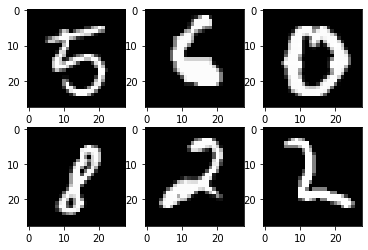

In [52]:
all_set = DigitsDataset(TRAIN_PATH)
train_set, val_set = random_split(all_set, [37800, 4200])
train_loader = DataLoader(dataset=train_set, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(dataset=val_set, batch_size=BATCH_SIZE, shuffle=True)
train_iter = iter(train_loader)

samples, labels = next(train_iter)

for i in range(6):
    plt.subplot(2,3, i+1)
    plt.imshow(samples[i][0], cmap="gray")
plt.show()


In [53]:
model = ConvNeuralNet(NUM_CLASSES)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
n_total_batches = len(train_loader)
n_total_val_batches = len(val_loader)
epoch_avg_train_loss_list = []
epoch_avg_val_loss_list = []
curr_avg_val_loss = 1000

for epoch in range(NUM_EPOCHS):

    model.eval()
    new_avg_val_loss = 0
    
    with torch.no_grad():

        for i, (samples, labels) in enumerate(val_loader):
            samples = samples.to(device)
            outputs = model(samples)
            loss = criterion(outputs, labels)
            new_avg_val_loss += loss.item()
    new_avg_val_loss = new_avg_val_loss / n_total_val_batches

    if (new_avg_val_loss <= curr_avg_val_loss):
        curr_avg_val_loss = new_avg_val_loss
        epoch_avg_val_loss_list.append(curr_avg_val_loss)
        torch.save(model.state_dict(), DATA_PATH + "best_model.pt")
    else:
        break


    epoch_avg_train_loss = 0
    model.train()

    for i, (samples, labels) in enumerate(train_loader):
        samples = samples.to(device)
        outputs = model(samples)
        
        loss = criterion(outputs, labels)
        epoch_avg_train_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    epoch_avg_train_loss = epoch_avg_train_loss / n_total_batches
    epoch_avg_train_loss_list.append(epoch_avg_train_loss)
    
    print(f'Epoch {epoch+1}, Average Training Loss: {epoch_avg_train_loss:.4f}, Average Validation Loss: {curr_avg_val_loss:.4f}')




Epoch 1, Average Training Loss: 0.6229, Average Validation Loss: 16.1282
Epoch 2, Average Training Loss: 0.0553, Average Validation Loss: 0.0760
Epoch 3, Average Training Loss: 0.0398, Average Validation Loss: 0.0737
Epoch 4, Average Training Loss: 0.0258, Average Validation Loss: 0.0624
Epoch 5, Average Training Loss: 0.0264, Average Validation Loss: 0.0563


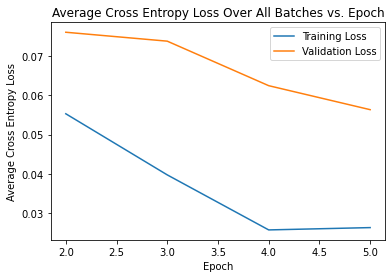

In [54]:
plt.figure()
plt.title("Average Cross Entropy Loss Over All Batches vs. Epoch")
plt.ylabel("Average Cross Entropy Loss")
plt.xlabel("Epoch")
plt.plot([i+1 for i in range(len(epoch_avg_train_loss_list))][1:], epoch_avg_train_loss_list[1:], label="Training Loss")
plt.plot([i+1 for i in range(len(epoch_avg_val_loss_list))][1:], epoch_avg_val_loss_list[1:], label="Validation Loss")
plt.legend()
plt.show()

2


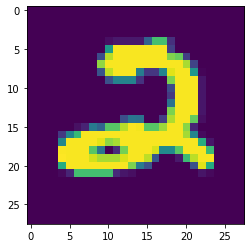

0


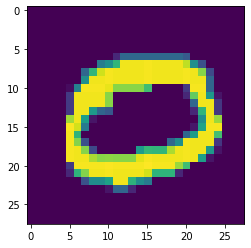

9


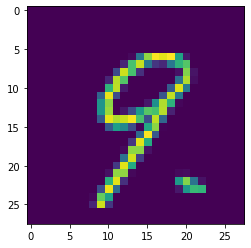

9


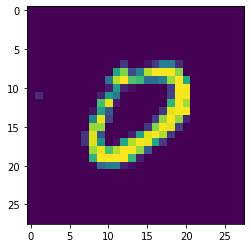

3


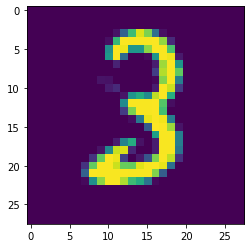

7


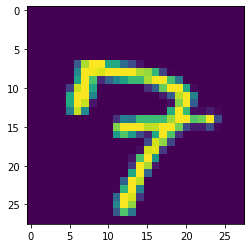

0


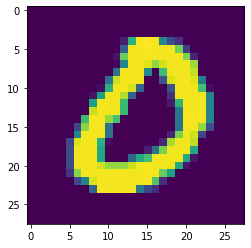

3


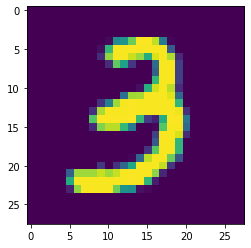

0


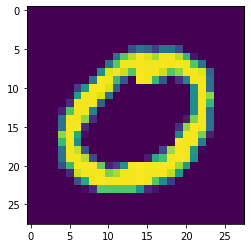

3


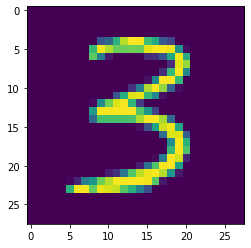

5


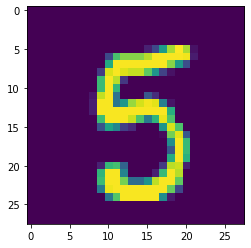

7


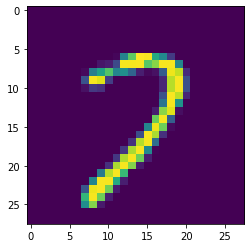

4


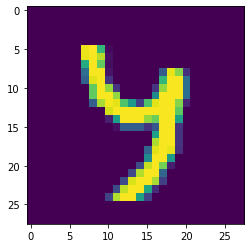

0


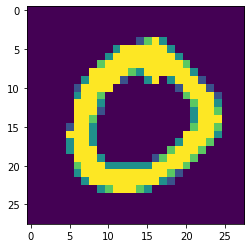

4


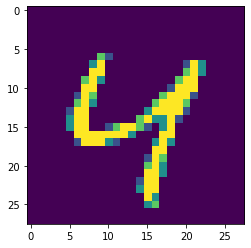

3


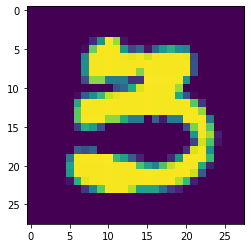

3


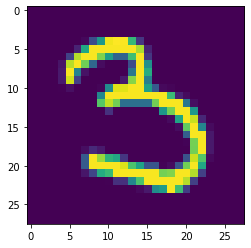

1


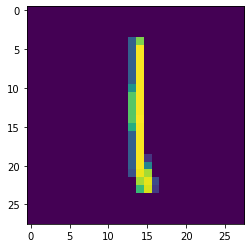

9


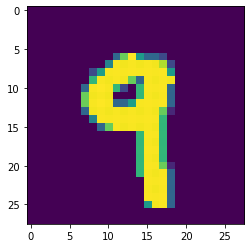

0


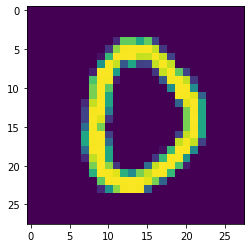

In [55]:
# Test the model
# In test phase, we don't need to compute gradients (for memory efficiency
test_model = ConvNeuralNet(NUM_CLASSES)
test_model.load_state_dict(torch.load(DATA_PATH + "best_model.pt"))
test_model.eval()

test_csv = pd.read_csv(TEST_PATH)
N = len(test_csv)
predict_df = pd.DataFrame(columns=['ImageId','Label'])

with torch.no_grad():

    for i in range(N):
        image = torch.tensor(test_csv.iloc[i, :]).reshape(-1,IMAGE_SIZE,IMAGE_SIZE).to(torch.float32).to(device)
        output = torch.argmax(test_model(image)).item()

        if (i+1 <= 20):
            print(output)
            plt.figure()
            plt.imshow(image[0])
            plt.show()
            
        predict_df = predict_df.append({'ImageId': i+1, 'Label': output}, ignore_index=True)

In [56]:
predict_df.to_csv(TEST_OUTPUT_PATH, index=False)